In [1]:
import numpy as np
import cv2 # OpenCV biblioteka
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial import distance
import csv
import os
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
BIN_THRESHOLD = 100
CARD_MIN_HW = 300
CARD_MAX_HW = 2000
EPSILON = 0.05
SEPARATE_CROP_Y = 37
CARD_MIN_HW = 300
CARD_MAX_HW = 2000
EPSILON = 0.05
CROP_Y0 = 5
CROP_H = 72
CROP_X0 = 2
CROP_W = 22
SEPARATE_CROP_Y = 37
CROP_THRESHOLD = 150
RANKS = ['2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K', 'A']
SUITS = ['C', 'D', 'H', 'S']

def format_result(rank, suit):
    rankp = RANKS[np.argmax(rank)]
    rank_perc = np.amax(rank)
    suitp = SUITS[np.argmax(suit)]
    suit_perc = np.amax(suit)
    return 'Result: ' + rankp + suitp + '[' + str(round(rank_perc * 100,2)) + '%, ' + str(round(suit_perc * 100,2)) +'%]'

In [3]:
%matplotlib inline 
matplotlib.rcParams['figure.figsize'] = 16,12

In [4]:
def create_output(number, length, index):
    tmp = []
    for i in range (0, number):
        x = np.zeros(length)
        x[index] = 1
        tmp.append(x)
    return tmp

def resize_rank(image):
    return cv2.resize(image, (20,27), interpolation = cv2.INTER_NEAREST)

def resize_suit(image):
    return cv2.resize(image, (22,22), interpolation = cv2.INTER_NEAREST)

def prepare_image_suit(image):
    #roi = localize_suit(image)
    roi = image
    roi = resize_suit(roi)
    roi = roi/255
    return roi.flatten()

def prepare_image_rank(image):
    #roi = localize_rank(image)
    roi = image
    roi = resize_rank(roi)
    roi = roi/255
    return roi.flatten()

def localize_suit(image):
    inv_image = cv2.bitwise_not(image)
    img, contours, hierarchy = cv2.findContours(inv_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    region = None
    for contour in contours: 
        x,y,w,h = cv2.boundingRect(contour)
        if w > 8 and h > 8:
            region = img[y:y+h+1,x:x+w+1]
            break
    if region is not None:
        return region
    else:
        return image
    
def localize_rank(image):
    inv_image = cv2.bitwise_not(image)
    img, contours, hierarchy = cv2.findContours(inv_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    region = None
    for contour in contours: 
        x,y,w,h = cv2.boundingRect(contour)
        if w > 8 and h > 10:
            region = img[y:y+h+1,x:x+w+1]
            break
    if region is not None:
        return region
    else:
        return image

def create_ann_suits():
    ann = Sequential()
    ann.add(Dense(90, input_dim=484, activation='sigmoid'))
    ann.add(Dense(4, activation='sigmoid'))
    return ann

def create_ann_ranks():
    ann = Sequential()
    ann.add(Dense(128, input_dim=540, activation='sigmoid'))
    ann.add(Dense(13, activation='sigmoid'))
    return ann
    
def train_ann_rank(ann, X_train, y_train):
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, np.float32)
   
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    ann.fit(X_train, y_train, epochs=600, batch_size=3, verbose = 0, shuffle=False) 
      
    return ann

def train_ann_suit(ann, X_train, y_train):
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, np.float32)
   
    sgd = SGD(lr=0.01, momentum=0.5)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    ann.fit(X_train, y_train, epochs=600, batch_size=3, verbose = 0, shuffle=False) 
      
    return ann

In [5]:
path = os.getcwd()

clubs_file = os.path.join(path, 'suits', 'C', 'count.txt')
fh = open(clubs_file, 'r')
clubs_cnt = int(fh.read())
fh.close()

diams_file = os.path.join(path, 'suits', 'D', 'count.txt')
fh = open(clubs_file, 'r')
diams_cnt = int(fh.read())
fh.close()

hearts_file = os.path.join(path, 'suits', 'H', 'count.txt')
fh = open(hearts_file, 'r')
hearts_cnt = int(fh.read())
fh.close()

spades_file = os.path.join(path, 'suits', 'S', 'count.txt')
fh = open(spades_file, 'r')
spades_cnt = int(fh.read())
fh.close()

ranks_cnt = []
for i in range(0, 8):
    file_name = os.path.join(path, 'ranks', str(i+2), 'count.txt')
    fh = open(file_name,'r')
    ranks_cnt.append(int(fh.read()))
    fh.close()

tens_file = os.path.join(path, 'ranks', 'T', 'count.txt')
fh = open(tens_file,'r')
ranks_cnt.append(int(fh.read()))
fh.close()

jacks_file = os.path.join(path, 'ranks', 'J', 'count.txt')
fh = open(jacks_file,'r')
ranks_cnt.append(int(fh.read()))
fh.close()

queens_file = os.path.join(path, 'ranks', 'Q', 'count.txt')
fh = open(queens_file,'r')
ranks_cnt.append(int(fh.read()))
fh.close()

kings_file = os.path.join(path, 'ranks', 'K', 'count.txt')
fh = open(kings_file,'r')
ranks_cnt.append(int(fh.read()))
fh.close()

aces_file = os.path.join(path, 'ranks', 'A', 'count.txt')
fh = open(aces_file,'r')
ranks_cnt.append(int(fh.read()))
fh.close()

suit_input = []
suit_output = []
for i in range(1, clubs_cnt + 1):
    file = os.path.join(path, 'suits', 'C', str(i) + '.jpg')
    img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
    prepared = prepare_image_suit(img)
    suit_input.append(prepared)
suit_output.extend(create_output(clubs_cnt, 4, 0))

for i in range(1, diams_cnt + 1):
    file = os.path.join(path, 'suits', 'D', str(i) + '.jpg')
    img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
    prepared = prepare_image_suit(img)
    suit_input.append(prepared)
suit_output.extend(create_output(diams_cnt, 4, 1))

for i in range(1, hearts_cnt + 1):
    file = os.path.join(path, 'suits', 'H', str(i) + '.jpg')
    img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
    prepared = prepare_image_suit(img)
    suit_input.append(prepared)
suit_output.extend(create_output(hearts_cnt, 4, 2))

for i in range(1, spades_cnt + 1):
    file = os.path.join(path, 'suits', 'S', str(i) + '.jpg')
    img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
    prepared = prepare_image_suit(img)
    suit_input.append(prepared)
suit_output.extend(create_output(spades_cnt, 4, 3))

rank_input = []
rank_output = []
for i in range(0,8):
    for g in range(1, ranks_cnt[i] + 1):
        file = os.path.join(path, 'ranks', str(i + 2), str(g) + '.jpg')
        img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
        prepared = prepare_image_rank(img)
        rank_input.append(prepared)
    rank_output.extend(create_output(ranks_cnt[i], 13, i))

for g in range(1, ranks_cnt[8] + 1):
    file = os.path.join(path, 'ranks', 'T', str(g) + '.jpg')
    img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
    prepared = prepare_image_rank(img)
    rank_input.append(prepared)
rank_output.extend(create_output(ranks_cnt[8], 13, 8))

for g in range(1, ranks_cnt[9] + 1):
    file = os.path.join(path, 'ranks', 'J', str(g) + '.jpg')
    img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
    prepared = prepare_image_rank(img)
    rank_input.append(prepared)
rank_output.extend(create_output(ranks_cnt[9], 13, 9))

for g in range(1, ranks_cnt[10] + 1):
    file = os.path.join(path, 'ranks', 'Q', str(g) + '.jpg')
    img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
    prepared = prepare_image_rank(img)
    rank_input.append(prepared)
rank_output.extend(create_output(ranks_cnt[10], 13, 10))

for g in range(1, ranks_cnt[11] + 1):
    file = os.path.join(path, 'ranks', 'K', str(g) + '.jpg')
    img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
    prepared = prepare_image_rank(img)
    rank_input.append(prepared)
rank_output.extend(create_output(ranks_cnt[11], 13, 11))

for g in range(1, ranks_cnt[12] + 1):
    file = os.path.join(path, 'ranks', 'A', str(g) + '.jpg')
    img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
    prepared = prepare_image_rank(img)
    rank_input.append(prepared)
rank_output.extend(create_output(ranks_cnt[12], 13, 12))

ann_suits = create_ann_suits()
ann_suits = train_ann_suit(ann_suits, suit_input, suit_output)

ann_ranks = create_ann_ranks()
ann_ranks = train_ann_rank(ann_ranks, rank_input, rank_output)

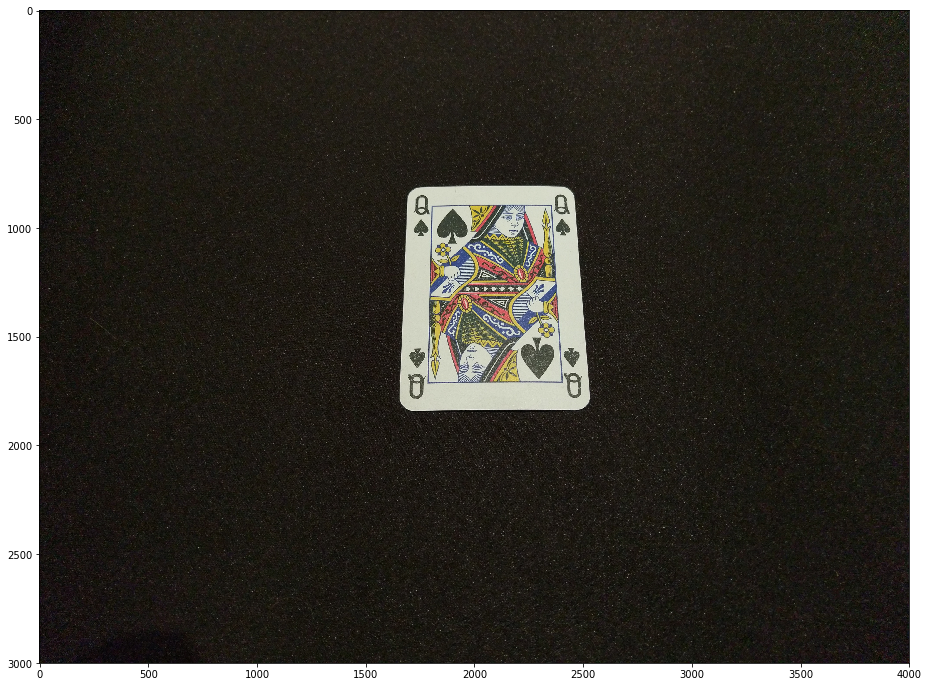

In [66]:
img = cv2.imread('test/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

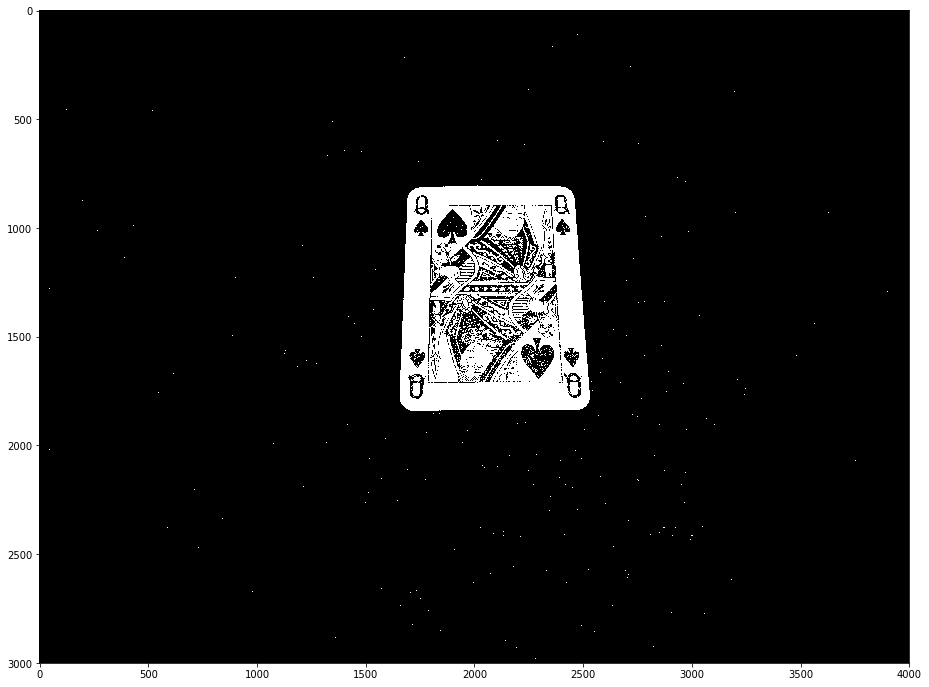

In [67]:
img_gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
ret, img_bin = cv2.threshold(img_gs, 100,255,cv2.THRESH_BINARY)

plt.imshow(img_bin, 'gray')

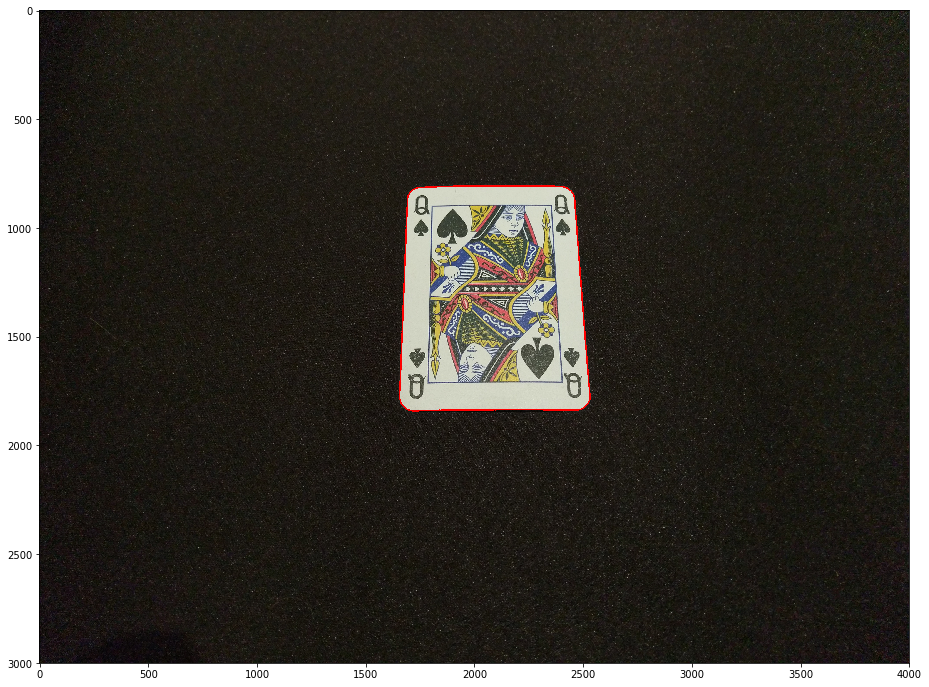

In [68]:
img1, contours, hierarchy = cv2.findContours(img_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contours_card = []
i = 0
for contour in contours:
    center, size, angle = cv2.minAreaRect(contour)
    width, height = size
    epsilon = EPSILON * cv2.arcLength(contour,True)
    approx = cv2.approxPolyDP(contour,epsilon,True)
    if width > CARD_MIN_HW and width < CARD_MAX_HW and height > CARD_MIN_HW and height < CARD_MAX_HW and len(approx) == 4 and hierarchy[0][i][3] == -1:
        contours_card.append(contour)
    i += 1

image_show = img.copy()
cv2.drawContours(image_show, contours_card, -1, (255, 0, 0), 5)
plt.imshow(image_show)

In [69]:
znakovi = []
boje = []
for trazena_kontura in contours_card:
    x,y,w,h = cv2.boundingRect(trazena_kontura)
    image_show = img.copy()
    cv2.rectangle(image_show,(x,y),(x+w,y+h),(0,255,0),5)
    rect = cv2.minAreaRect(trazena_kontura)
    rect = cv2.boxPoints(rect)
    rect = np.int0(rect)
    
    epsilon = EPSILON * cv2.arcLength(trazena_kontura,True)
    approx = cv2.approxPolyDP(trazena_kontura,epsilon,True)
    pts = [[approx[0][0][0], approx[0][0][1]], [approx[1][0][0], approx[1][0][1]], [approx[2][0][0], approx[2][0][1]], [approx[3][0][0], approx[3][0][1]]]
    pts = np.float32(pts)

    temp_rect = np.zeros((4,2), dtype = "float32")

    xSorted = pts[np.argsort(pts[:, 0]), :]

    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost

    D = distance.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]

    if distance.euclidean(bl,br) >= distance.euclidean(bl,tl):
        temp_rect[0] = bl
        temp_rect[1] = tl
        temp_rect[2] = tr
        temp_rect[3] = br
    else:
        temp_rect[0] = tl
        temp_rect[1] = tr
        temp_rect[2] = br
        temp_rect[3] = bl
    maxWidth = 200
    maxHeight = 300

    dst = np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0, maxHeight-1]], np.float32)
    M = cv2.getPerspectiveTransform(temp_rect,dst)
    warp = cv2.warpPerspective(img, M, (maxWidth, maxHeight))
    
    crop_warp = warp[CROP_Y0:CROP_Y0 + CROP_H, CROP_X0:CROP_X0 + CROP_W]
    crop_gs = cv2.cvtColor(crop_warp, cv2.COLOR_RGB2GRAY)
    ret, crop_bin = cv2.threshold(crop_gs, CROP_THRESHOLD,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    znak_crop = crop_bin[0:SEPARATE_CROP_Y, 0:CROP_W]
    boja_crop = crop_bin[SEPARATE_CROP_Y:CROP_H, 0:CROP_W]
    
    znakovi.append(znak_crop)
    boje.append(boja_crop)
print('Primeceno je ' + str(len(znakovi)) + ' karata')

Primeceno je 1 karata


In [70]:
for i in range(0, len(znakovi)):
    rank_prep = prepare_image_rank(znakovi[i])
    suit_prep = prepare_image_suit(boje[i])
    rank_in = [rank_prep]
    suit_in = [suit_prep]

    suit_res = ann_suits.predict(np.array(suit_in, np.float32))
    rank_res = ann_ranks.predict(np.array(rank_in, np.float32))
    print(format_result(rank_res, suit_res))

Result: 9S[27.66%, 71.07%]
